In [1]:
pip install pyspellchecker


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import re
from spellchecker import SpellChecker
from collections import Counter
import copy


In [3]:
book_fname = 'sherlockholmes.txt'
fid = open(book_fname, "r")
book_data = fid.read()
fid.close()

unique_chars = list(set(book_data))
# length K corresponds to the dimensionality of output + input vector of RNN
K = len(unique_chars)
char_to_ind = {}
ind_to_char = {}
ind = 0
for char in unique_chars:
    char_to_ind[char] = ind
    ind_to_char[ind] = char
    ind+=1
char_to_ind

{'_': 0,
 '™': 1,
 'A': 2,
 '½': 3,
 '%': 4,
 'V': 5,
 'i': 6,
 'æ': 7,
 'I': 8,
 '6': 9,
 ',': 10,
 ':': 11,
 '!': 12,
 'z': 13,
 'c': 14,
 'r': 15,
 'K': 16,
 'E': 17,
 'j': 18,
 'm': 19,
 '0': 20,
 '9': 21,
 'G': 22,
 '?': 23,
 '‘': 24,
 'T': 25,
 'u': 26,
 'q': 27,
 'h': 28,
 'â': 29,
 '\n': 30,
 'e': 31,
 'à': 32,
 ' ': 33,
 'M': 34,
 '•': 35,
 'Y': 36,
 'Z': 37,
 'é': 38,
 '’': 39,
 'y': 40,
 ';': 41,
 'n': 42,
 'N': 43,
 '$': 44,
 'O': 45,
 'x': 46,
 '£': 47,
 'B': 48,
 '.': 49,
 'f': 50,
 'F': 51,
 '8': 52,
 '4': 53,
 'w': 54,
 '”': 55,
 'X': 56,
 'd': 57,
 'Q': 58,
 '*': 59,
 '1': 60,
 'C': 61,
 's': 62,
 'a': 63,
 'o': 64,
 '-': 65,
 'U': 66,
 '—': 67,
 '7': 68,
 'H': 69,
 'L': 70,
 'W': 71,
 'R': 72,
 '(': 73,
 'D': 74,
 '2': 75,
 'p': 76,
 '3': 77,
 '“': 78,
 '/': 79,
 'v': 80,
 'b': 81,
 'œ': 82,
 'l': 83,
 't': 84,
 'g': 85,
 'è': 86,
 'S': 87,
 ')': 88,
 'J': 89,
 '&': 90,
 '5': 91,
 'P': 92,
 'k': 93}

In [4]:
encoded_text = [char_to_ind[c] for c in book_data]
encoded_text

[25,
 28,
 31,
 33,
 2,
 57,
 80,
 31,
 42,
 84,
 26,
 15,
 31,
 62,
 33,
 64,
 50,
 33,
 87,
 28,
 31,
 15,
 83,
 64,
 14,
 93,
 33,
 69,
 64,
 83,
 19,
 31,
 62,
 30,
 30,
 81,
 40,
 33,
 2,
 15,
 84,
 28,
 26,
 15,
 33,
 61,
 64,
 42,
 63,
 42,
 33,
 74,
 64,
 40,
 83,
 31,
 30,
 30,
 8,
 49,
 33,
 2,
 33,
 87,
 61,
 2,
 43,
 74,
 2,
 70,
 33,
 8,
 43,
 33,
 48,
 45,
 69,
 17,
 34,
 8,
 2,
 30,
 30,
 30,
 8,
 49,
 30,
 30,
 25,
 64,
 33,
 87,
 28,
 31,
 15,
 83,
 64,
 14,
 93,
 33,
 69,
 64,
 83,
 19,
 31,
 62,
 33,
 62,
 28,
 31,
 33,
 6,
 62,
 33,
 63,
 83,
 54,
 63,
 40,
 62,
 33,
 0,
 84,
 28,
 31,
 0,
 33,
 54,
 64,
 19,
 63,
 42,
 49,
 33,
 8,
 33,
 28,
 63,
 80,
 31,
 33,
 62,
 31,
 83,
 57,
 64,
 19,
 33,
 28,
 31,
 63,
 15,
 57,
 33,
 28,
 6,
 19,
 30,
 19,
 31,
 42,
 84,
 6,
 64,
 42,
 33,
 28,
 31,
 15,
 33,
 26,
 42,
 57,
 31,
 15,
 33,
 63,
 42,
 40,
 33,
 64,
 84,
 28,
 31,
 15,
 33,
 42,
 63,
 19,
 31,
 49,
 33,
 8,
 42,
 33,
 28,
 6,
 62,
 33,
 31,
 40,
 31,
 62,
 33

In [5]:
class TextDataset(Dataset):
    def __init__(self, data, seq_length):
        self.seq_length = seq_length
        self.data = data

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        input_seq = self.data[idx:idx+self.seq_length]
        target_seq = self.data[idx+1:idx+self.seq_length+1]
        return torch.tensor(input_seq), torch.tensor(target_seq)


# Split training sequences into batches

In [6]:
# Batch size.
SEQ_LENGTH = 25
BATCH_SIZE = 32 # vocab size

dataset = TextDataset(encoded_text, SEQ_LENGTH)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [7]:
for input_batch, target_batch in data_loader:
    print("1st batch: input_text indices:", input_batch)
    print("\n1st batch: target_text indices:", target_batch)
    break

1st batch: input_text indices: tensor([[93, 31, 15, 33, 87, 84, 15, 31, 31, 84, 10, 33, 81, 26, 84, 33, 69, 64,
         83, 19, 31, 62, 33, 28, 63],
        [15, 15, 64, 81, 64, 15, 63, 84, 31, 33, 40, 64, 26, 15, 33, 80,  6, 31,
         54, 49, 33, 48, 26, 84, 33],
        [15, 40, 33, 42, 63, 15, 15, 63, 84,  6, 80, 31, 49, 33, 25, 28, 31, 42,
         33, 87, 28, 31, 15, 83, 64],
        [84, 28, 64, 26, 85, 28, 84, 62, 33, 63, 15, 31, 33, 42, 64, 84, 30, 64,
         80, 31, 15, 65, 76, 83, 31],
        [63, 62, 33, 81, 31, 31, 42, 33, 63, 33, 19, 64, 62, 84, 33, 31, 42, 84,
         31, 15, 84, 63,  6, 42,  6],
        [31, 15, 33, 31, 42, 57, 10, 33, 54, 28,  6, 14, 28, 33, 54, 63, 62, 33,
         63, 33, 28, 26, 42, 57, 15],
        [57, 33, 26, 76, 54, 63, 15, 57, 33, 84, 64, 33, 84, 28, 31, 33, 14, 31,
          6, 83,  6, 42, 85, 49, 33],
        [23, 55, 30, 30, 78, 48, 26, 84, 33, 54, 28, 63, 84, 33, 64, 84, 28, 31,
         15, 33,  6, 62, 33, 84, 28],
        [33, 54, 

## Initialization

In [8]:
dataset = TextDataset(encoded_text, SEQ_LENGTH)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def init_RNN(m, K):
    RNN = {}
    RNN['b'] = torch.zeros((m, 1), device=device, requires_grad=True)
    RNN['c'] = torch.zeros((K, 1), device=device, requires_grad=True)
    U = torch.randn((m, K), device=device) * (1/np.sqrt(2*K))
    W = torch.randn((m, m), device=device) * (1/np.sqrt(2*m))
    V = torch.randn((K, m), device=device) * (1/np.sqrt(m))
    
    RNN['U'] = U.clone().detach().requires_grad_()
    RNN['W'] = W.clone().detach().requires_grad_()
    RNN['V'] = V.clone().detach().requires_grad_()
    
    return RNN

def softmax(x):
    return torch.nn.functional.softmax(x, dim=0)

def SynthesizeCharSeq(RNN, h0, x0, n, X_seq=None):
    W = RNN['W']
    U = RNN['U']
    V = RNN['V']
    b = RNN['b']
    c = RNN['c']

    K = V.shape[0]  # Vocabulary size
    Y = torch.zeros((K, n), device=device)
    h_old = h0
    x = x0
    
    with torch.no_grad():
        for t in range(n):
            a = W @ h_old + U @ x + b
            h = F.relu(a)
            o = V @ h + c
            p = F.softmax(o, dim=0)
            
            # Sample next character
            p_np = p.cpu().numpy().squeeze()
            cp = np.cumsum(p_np)
            a_rand = np.random.uniform()
            ii = np.argmax(cp - a_rand > 0)
            
            y = torch.zeros((K, 1), device=device)
            y[ii] = 1
            x = y
            
            Y[:, t:t+1] = y
            h_old = h
    
    return Y, a, o, p, h

def AdamTrain(RNN, seq_length, eta, m, update_max, book_data, data_loader, ind_to_char, K):
    e = 0
    epoch = 0
    update_step = 0
    
    smooth_losses = []
    steps = []
    current_best_loss = 100
    current_best_RNN = {}
    
    hprev = torch.zeros((m, 1), device=device)
    
    # Convert RNN parameters to a list for the optimizer
    params = []
    for k, v in RNN.items():
        params.append(v)
    
    # Create Adam optimizer
    optimizer = torch.optim.Adam(params, lr=eta, betas=(0.9, 0.999), eps=1e-8)
    
    for epoch in range(update_max):
        for X_batch, Y_batch in data_loader:
            X_batch = X_batch.to(device)  # (batch, seq)
            Y_batch = Y_batch.to(device)  # (batch, seq)

            B, T = X_batch.shape

            # One-hot encode inputs
            X_onehot = F.one_hot(X_batch, num_classes=K).float()  # (B, T, K)
        
            # Forward pass
            optimizer.zero_grad() 

            total_loss = torch.tensor(0.0, device=device)

            h = torch.zeros((B, m), device=device)
            
            # Manual forward pass for autograd to track
            for t in range(seq_length):
                # Get one-hot inputs for current time step
                xt = X_onehot[:, t, :]  # (B, K)
                
                # Compute hidden state
                a = h @ RNN['W'].t() + xt @ RNN['U'].t() + RNN['b'].t()
                h = F.relu(a)  # (B, m)
                
                # Compute output
                o = h @ RNN['V'].t() + RNN['c'].t()  # (B, K)
                
                # Get targets for this time step
                y_true = Y_batch[:, t]  # (B,)
                
                # Compute loss
                loss = F.cross_entropy(o, y_true)
                total_loss += loss
                            
            # Normalize loss
            total_loss /= seq_length
            
            # Backward pass
            total_loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(params, 5)
            
            # Update parameters
            optimizer.step()
            
            # Update smooth loss
            if update_step == 0:
                smooth_loss = total_loss.item()
            else:
                smooth_loss = .99 * smooth_loss + .01 * total_loss.item()

            if smooth_loss < current_best_loss:
                current_best_loss = smooth_loss
                current_best_RNN = copy.deepcopy(RNN)
        
            # Print progress
            if update_step % 1000 == 0:
                print(f"Update: {update_step} Smooth loss: {smooth_loss} Epoch {epoch}")
                smooth_losses.append(smooth_loss)
                steps.append(update_step)
            
            # Generate text sample
            if update_step % 10000 == 0:
                start_char_index = X_batch[0, 0].item()

                # Create one-hot vector for that character
                x0 = torch.zeros((K, 1), device=device)
                x0[start_char_index] = 1
                Y_new, _, _, _, _ = SynthesizeCharSeq(RNN, hprev, x0, 200)
                output_str = ''
                for j in range(Y_new.shape[1]):
                    ind_y = torch.argmax(Y_new[:, j]).item()
                    output_str += ind_to_char[ind_y]
                print(output_str)
            
            update_step += 1
            e += seq_length
            if e > len(book_data)-seq_length-1:
                e = 0
                epoch += 1
                hprev = torch.zeros((m, 1), device=device)
    
    return smooth_losses, steps, current_best_RNN

Start training:

In [9]:
# m = 100 # hidden state dimensionality
m = 300
eta = 0.001

RNN = init_RNN(m, K)
RNN["b"].shape, RNN['U'].shape, RNN['W'].shape, RNN['V'].shape, RNN['c'].shape

seq_length = 25
update_max = 10
losses, steps, best_RNN = AdamTrain(RNN, seq_length, eta, m, update_max, 
                         book_data, data_loader, ind_to_char, K)

Update: 0 Smooth loss: 4.545547962188721 Epoch 0
d½œtiTC)m:IT.Yn‘YNPemJxH9FMwz9ZyHI9Ah
-&N)£-”q•£&i‘L‘52
’•92%q$8$0dqe_r(àhx-0$zjeIèL9YgXv( )™T—C½gg/iU-EèQEà%”Z3N.b(G0lU‘&s tp”y2WYOwàbF”2éR
GaNâ9Q£141™f_yjdæ£2GG;,—NO *,’!c)tâO:f?M?!/LG‘08
M.V!té9f/8
Update: 1000 Smooth loss: 1.98550663709543 Epoch 0
Update: 2000 Smooth loss: 1.7923538534546564 Epoch 0
Update: 3000 Smooth loss: 1.6877673984329304 Epoch 0
Update: 4000 Smooth loss: 1.6167693430739851 Epoch 0
Update: 5000 Smooth loss: 1.5677954157613128 Epoch 0
Update: 6000 Smooth loss: 1.5388709505450073 Epoch 0
Update: 7000 Smooth loss: 1.5160261233847376 Epoch 0
Update: 8000 Smooth loss: 1.4952712374538262 Epoch 0
Update: 9000 Smooth loss: 1.4817520905952122 Epoch 0
Update: 10000 Smooth loss: 1.4580721617349799 Epoch 0
df on gives again. Do you very mouth, you would congirspess.” The sccortainly 2,
only disposition wornow lave in the waiting
to everytice as he had brevenoe, and what in a good me window.

O you?”

“W
Update: 11000 Smooth

In [11]:
# Generate final sample
h0 = torch.zeros((m, 1), device=device)
x0 = torch.zeros((K, 1), device=device)
x0[char_to_ind[book_data[0]]] = 1

Y_new, _, _, _, _ = SynthesizeCharSeq(best_RNN, h0, x0, 1000, X_seq=None)
output_str = ''
for j in range(Y_new.shape[1]):
    ind_y = torch.argmax(Y_new[:, j]).item()
    output_str += ind_to_char[ind_y]
print("\nFinal generated sample:")
print(output_str)


Final generated sample:
Y He had complicate that you think, however, which were a marffer.

“The nervous each other, though the blow homering at the highestings in
the Underground at it, then? It is more seal.”

“Thank you. I must say, and I picked with any stairs again, laying round to
get, and I must ceatured is little
rug of been that he loved his fitten angle would see. You are news Balmorals in the wedding that the door had ever, Watson,” said I perhaps none of the one in the conday of the pullings, drawn some about the house is bunkness, able about a hard-byine of deach of envelope, with us, and in an electronic works Hank effected to yourcefed laughternce. I lefter was so.”

“And his cocknt and were is also name, and your business whe
me, for there was the dead—that the service.”

It was not if, as I suggestive conccuriat. It must have caught that
the very what did the other. I cannot pulled to the City.
She ever were
enough
and conclusivat this confistown which was she had bee

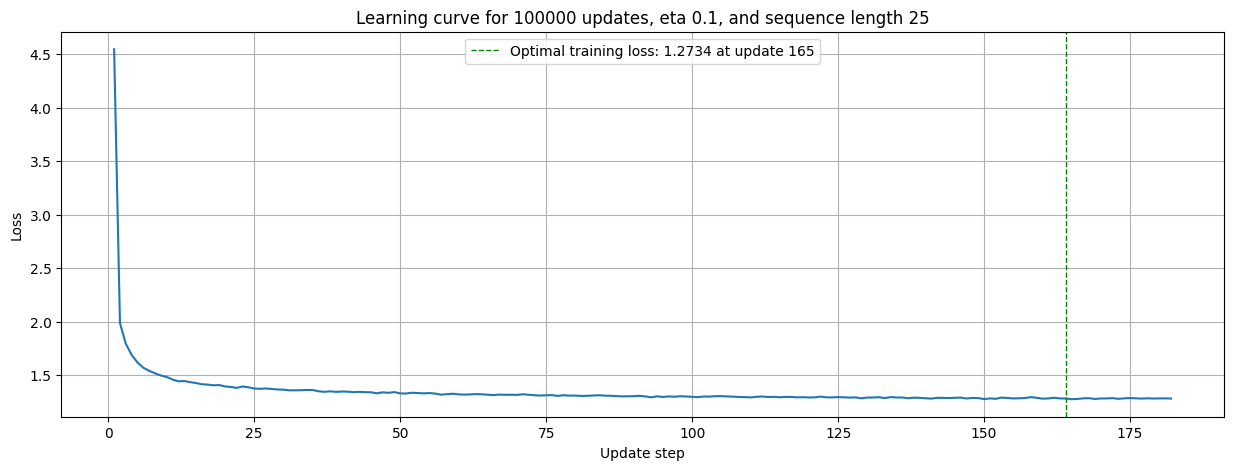

In [12]:
def plot_learning_curve(smooth_loss, title='', length_text=None, seq_length=None):
    
    # Plot the learning curve
    _, ax = plt.subplots(1, 1, figsize=(15,5))
    plt.title('Learning curve '+title)
    ax.plot(range(1, len(smooth_loss)+1), smooth_loss)
        
    # Find the optimal metric value and the corresponding update
    optimal_update = np.argmin(smooth_loss)
    optimal_loss = np.round(smooth_loss[optimal_update], 4)
    label = 'Optimal training loss: '+str(optimal_loss)+' at update '+str(optimal_update+1)
    ax.axvline(optimal_update, c='green', linestyle='--', linewidth=1, label=label)
        
    # Plot vertical red lines each epoch (if required)
    if length_text is not None and seq_length is not None:
        updates_per_epoch = len([e for e in range(0, length_text-1, seq_length) \
                                 if e<=length_text-seq_length-1])
        for e in range(updates_per_epoch, len(smooth_loss)+1, updates_per_epoch):
            label = 'Epoch'
            ax.axvline(e, c='red', linestyle='--', linewidth=1, label=label)
        
    # Add axis, legend and grid
    ax.set_xlabel('Update step')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)
figure=0
title = 'for 100000 updates, eta 0.1, and sequence length 25'
plot_learning_curve(losses, title=title, length_text=len(book_data), seq_length=25)
plt.savefig(str(figure)+'_Curve_100000.png', bbox_inches='tight'); figure+=1

# Evaluation

In [13]:
def evaluate_spelling_accuracy(generated_text):

    # Initialize spell checker
    spell = SpellChecker(language='en')
    
    # Clean the text and split into words
    cleaned_text = re.sub(r'[^\w\s]', ' ', generated_text.lower())
    words = [word for word in cleaned_text.split() if word.strip()]
    
    words = [word for word in words if word.isalpha() and len(word) > 1]
    
    # Count total words
    total_words = len(words)
    
    if total_words == 0:
        return {
            "correct_words": 0,
            "incorrect_words": 0,
            "total_words": 0,
            "spelling_accuracy": 0.0,
            "most_common_incorrect": []
        }
    
    # Find misspelled words
    misspelled = spell.unknown(words)
    
    # Count correct words
    correct_words = total_words - len(misspelled)
    
    # Calculate spelling accuracy
    spelling_accuracy = (correct_words / total_words) * 100
    
    # Get most common incorrect words
    incorrect_counter = Counter(misspelled)
    most_common_incorrect = incorrect_counter.most_common(10)
    
    # Return metrics
    return {
        "correct_words": correct_words,
        "incorrect_words": len(misspelled),
        "total_words": total_words,
        "spelling_accuracy": spelling_accuracy,
        "most_common_incorrect": most_common_incorrect
    }

In [14]:
metrics = evaluate_spelling_accuracy(output_str)
metrics

{'correct_words': 160,
 'incorrect_words': 17,
 'total_words': 177,
 'spelling_accuracy': 90.3954802259887,
 'most_common_incorrect': [('cocknt', 1),
  ('remarke', 1),
  ('ceatured', 1),
  ('bunkness', 1),
  ('byine', 1),
  ('fitten', 1),
  ('conclusivat', 1),
  ('yourcefed', 1),
  ('highestings', 1),
  ('laughternce', 1)]}

In [ ]:
def grid_search_hyperparameters(encoded_text, TextDataset, ind_to_char, K, book_data):
    # Define the hyperparameter grid
    batch_sizes = [32, 64, 94, 128]
    learning_rates = [0.0001, 0.0005, 0.001, 0.002]
    
    # Fixed parameters
    seq_length = 25
    m = 300  # hidden state dimension
    update_max = 2  # Reduce number of epochs for grid search to save time
    
    # Store results
    results = []
    
    # Set random seed for reproducibility
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Run grid search
    for batch_size in batch_sizes:
        for eta in learning_rates:
            print(f"\nTesting batch_size={batch_size}, eta={eta}")
            
            # Create dataset and dataloader with current batch size
            dataset = TextDataset(encoded_text, seq_length)
            data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
            
            # Initialize RNN
            RNN = init_RNN(m, K)
            
            # Train and get loss
            smooth_losses, steps, _ = AdamTrain(RNN, seq_length, eta, m, update_max, 
                                           book_data, data_loader, ind_to_char, K)
            
            # Store final smooth loss and hyperparameters
            final_loss = smooth_losses[-1] if smooth_losses else float('inf')
            results.append({
                'batch_size': batch_size,
                'eta': eta,
                'final_loss': final_loss,
                'losses': smooth_losses,
                'steps': steps
            })
            
            print(f"Final smooth loss: {final_loss}")
    
    # Find best hyperparameters
    best_result = min(results, key=lambda x: x['final_loss'])
    print("\n----- Grid Search Results -----")
    print(f"Best hyperparameters: batch_size={best_result['batch_size']}, eta={best_result['eta']}")
    print(f"Best final loss: {best_result['final_loss']}")
    
    # Visualize results
    plot_grid_search_results(results, batch_sizes, learning_rates)
    
    return results, best_result

def plot_grid_search_results(results, batch_sizes, learning_rates):
    # Create a grid for heatmap
    loss_grid = np.zeros((len(batch_sizes), len(learning_rates)))
    
    # Fill the grid with final losses
    for result in results:
        i = batch_sizes.index(result['batch_size'])
        j = learning_rates.index(result['eta'])
        loss_grid[i, j] = result['final_loss']
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(loss_grid, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Final Smooth Loss')
    
    # Set ticks and labels
    plt.xticks(np.arange(len(learning_rates)), learning_rates)
    plt.yticks(np.arange(len(batch_sizes)), batch_sizes)
    plt.xlabel('Learning Rate (eta)')
    plt.ylabel('Batch Size')
    plt.title('Grid Search Results: Final Smooth Loss')
    
    # Add text annotations to each cell
    for i in range(len(batch_sizes)):
        for j in range(len(learning_rates)):
            plt.text(j, i, f"{loss_grid[i, j]:.4f}", 
                     ha="center", va="center", color="w" if loss_grid[i, j] > np.mean(loss_grid) else "black")
    
    plt.tight_layout()
    plt.savefig('grid_search_results.png')
    plt.show()
    
    # Plot learning curves for each configuration
    plt.figure(figsize=(15, 10))
    for result in results:
        label = f"BS={result['batch_size']}, η={result['eta']}"
        plt.plot(result['steps'], result['losses'], label=label)
    
    plt.xlabel('Update Steps')
    plt.ylabel('Smooth Loss')
    plt.title('Learning Curves for Different Hyperparameter Configurations')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

results, best_config = grid_search_hyperparameters(encoded_text, TextDataset, ind_to_char, K, book_data)